# Swing Detection Time Series Analysis


Using Catapult wearable devices and shadow swinging (due to COVID-19 restrictions), we generated a dataset that includes forehand swings and backhand swings. This notebooks produces a K-means clustering analysis that can be used for swing detections, using both the standard and the 100hz Catapult datasets. Specifically, within the 100hz dataset, our goal is to identify the role of rotation and acceleration within the swing detection, and potentially apply this analysis to a time series analysis for swing detection. 


Author: Karthik Guruvayurappan 

In [11]:
# import packages for time series analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style('white')

### Format Datasets from Catapult Wearables into Pandas DataFrames

In [30]:
# import swing detection datasets from Catapult GPS devices
swing_detection = pd.read_csv('../Datasets/karthik_swing_detection.csv')
swing_detection_100hz = pd.read_csv('../Datasets/karthik_swing_detection_100hz.csv')

In [31]:
# view standard swing detection data
swing_detection.head()

,Timestamp,Seconds,Velocity,Acceleration,Odometer,Latitude,Longitude,Heart Rate,Player Load,Positional Quality (%),HDOP,#Sats,Unnamed: 12
0,48:28.9,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,-1.0,0,NaN
1,48:29.0,0.1,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,-1.0,0,NaN
2,48:29.1,0.2,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,-1.0,0,NaN
3,48:29.2,0.3,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,-1.0,0,NaN
4,48:29.3,0.4,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,-1.0,0,NaN


In [32]:
# view 100hz swing detection data
swing_detection_100hz.head()

,TimeStamp,Acceleration.forward,Acceleration.side,Acceleration.up,Rotation.roll,Rotation.pitch,Rotation.yaw,RawPlayerLoad,SmoothedPlayerLoad,imuAcceleration.forward,...,Longitude,Odometer,RawVelocity,SmoothedVelocity,GNSS.LPS.Acceleration,MetabolicPower,GNSS.Fix,GNSS.Strength,GNSS.HDOP,HeartRate
0,00:00.0,-0.922020,-0.008228,0.257004,-12.688,-4.941,4.270,0.506348,0.097728,-0.917566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,00:00.0,-0.927828,-0.007260,0.260876,-14.335,-5.063,4.758,0.241211,0.098716,-0.918521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,00:00.0,-0.929280,-0.009680,0.265232,-15.372,-3.782,4.941,0.115234,0.099575,-0.914655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,00:00.0,-0.936540,-0.005808,0.267652,-15.494,-2.623,4.575,0.057617,0.100299,-0.916248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,00:00.0,-0.943800,-0.007744,0.264748,-14.823,-2.013,2.928,0.030273,0.100887,-0.917892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### Exploratory Data Analysis (EDA)

Since the first half of the session was spent swinging forehands, while the second half of the session was spent swining backhands, there should be identifiable trends and differences between the first and second half of the data. In addition, to add variability within the dataset, there were a variety of forehands taken, including inside-out forehands, approach shots, lobs, slices, and topspin forehands. 

After discussing among ourselves, our hypothesis was that there would be visible trends in the 100hz dataset. Specifically, we were interested in the yaw rotation (rotation around the z-axis), and the acceleration upward, since swings generally move from low to high. 

In [33]:
# get size of 100hz dataset
swing_detection_100hz_mod = swing_detection_100hz.iloc[::10, :]
swing_100hz_number = len(swing_detection_100hz.index)
swing_100hz_number

122652

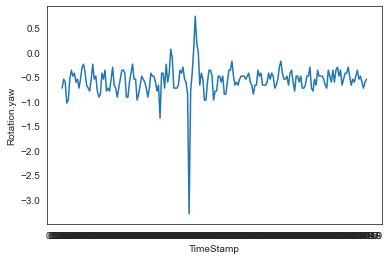

In [36]:
# generate time series plot for forehand 
sns.lineplot(x='TimeStamp', y='Rotation.yaw', data=swing_detection_100hz_mod[3000:3200])

### Scratch Work

In [75]:
hertz_mod = 100
swing_detection_100hz_mod = swing_detection_100hz.iloc[::hertz_mod, :]
swing_detection_100hz_mod

,TimeStamp,Acceleration.forward,Acceleration.side,Acceleration.up,Rotation.roll,Rotation.pitch,Rotation.yaw,RawPlayerLoad,SmoothedPlayerLoad,imuAcceleration.forward,...,Longitude,Odometer,RawVelocity,SmoothedVelocity,GNSS.LPS.Acceleration,MetabolicPower,GNSS.Fix,GNSS.Strength,GNSS.HDOP,HeartRate
0,00:00.0,-0.922020,-0.008228,0.257004,-12.688,-4.941,4.270,0.506348,0.097728,-0.917566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
100,00:01.0,-0.957836,0.099704,0.188276,-24.644,13.054,-5.246,0.008789,0.099683,-0.177926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
200,00:02.0,-0.968484,0.086152,0.743908,-57.462,-116.388,-48.678,0.019531,0.297282,-0.242520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
300,00:03.0,0.156816,-0.762784,0.790856,247.904,197.518,-103.822,0.049316,0.327458,0.142195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
400,00:04.0,-0.445764,0.229900,0.600644,-43.676,-54.961,-31.903,0.027832,0.206247,0.038869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122200,20:22.0,-0.947188,-0.253616,0.196504,0.305,4.270,8.174,0.013672,0.119483,0.024589,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
122300,20:23.0,-0.944284,-0.174724,0.108900,14.579,0.915,-24.888,0.018555,0.083474,-0.067978,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
122400,20:24.0,-0.948156,-0.259908,0.203280,-5.490,-8.662,9.760,0.026367,0.156433,0.004330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
122500,20:25.0,-0.985424,-0.339284,0.054208,-4.270,-9.089,-41.907,0.026367,0.177984,0.038632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


There are three types of rotation presented in the 100hz dataset for swings. Yaw rotation represents rotation around the z-axis, which is what will be particularly applicable to performing a K-means clustering for this dataset

## Generate Exploratory Data Plots for K Means

In [76]:
# isolate yaw rotation data
yaw_rotation = swing_detection_100hz['Rotation.yaw']
yaw_rotation

0          4.270
1          4.758
2          4.941
3          4.575
4          2.928
           ...  
122647    22.631
122648    18.178
122649    22.753
122650    27.877
122651    62.586
Name: Rotation.yaw, Length: 122652, dtype: float64

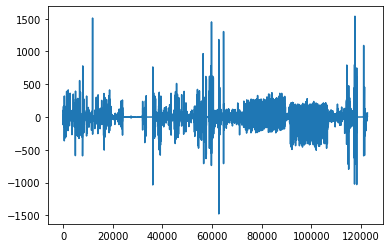

In [77]:
# plot yaw rotation data
plt.plot(yaw_rotation)

In [78]:
# isolate side acceleration data
side_accel = swing_detection_100hz['Acceleration.side']
side_accel

0        -0.008228
1        -0.007260
2        -0.009680
3        -0.005808
4        -0.007744
            ...   
122647   -0.253616
122648   -0.200376
122649   -0.195536
122650   -0.222640
122651   -0.275396
Name: Acceleration.side, Length: 122652, dtype: float64

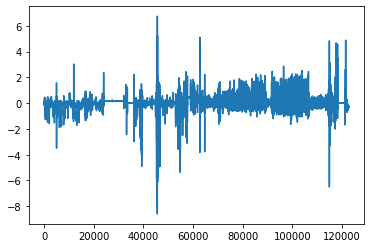

In [79]:
# plot sideways acceleration
plt.plot(side_accel)

In [80]:
# isolate player load
player_load = swing_detection_100hz['RawPlayerLoad']
player_load

0         0.506348
1         0.241211
2         0.115234
3         0.057617
4         0.030273
            ...   
122647    0.026856
122648    0.018066
122649    0.020019
122650    0.015625
122651    0.257324
Name: RawPlayerLoad, Length: 122652, dtype: float64

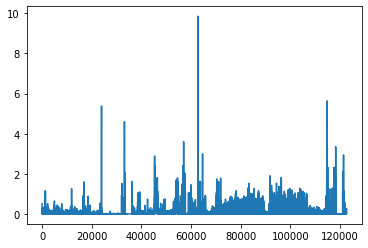

In [81]:
# plot player load
plt.plot(player_load)

## Create K Means Analysis

In [97]:
# create K Means object
kmeans = KMeans(n_clusters = 2)

In [98]:
# create 2D array for K Means
kmeans_data = []

for i in range(len(yaw_rotation)):
    kmeans_data.append([yaw_rotation[i], side_accel[i]])

In [99]:
kmeans.fit(kmeans_data)

KMeans(n_clusters=2)

In [100]:
centroids = kmeans.cluster_centers_

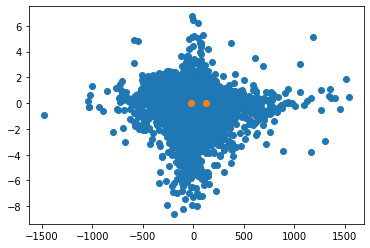

In [101]:
plt.scatter(yaw_rotation, side_accel)
plt.scatter(centroids[:, 0], centroids[:, 1])